## #7.1 Import treatment information

In [1]:
import pandas as pd

df_response = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/7_final/SummaryResponseTable_MMAE3.csv', sep=';') # SummaryResponseTable_maui_4 SummaryResponseTable2= MOFA,

#df_response = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/7_final/SummaryResponseTable_MMAE3.csv', sep=';') # SummaryResponseTable_maui_4 SummaryResponseTable2= MOFA,
df_response['Cluster'] = df_response['Cluster'] + 1

# create dummy variables
just_dummies = pd.get_dummies(df_response['Cluster'])

df_response = pd.concat([df_response, just_dummies], axis=1)   
df_response = df_response.rename(columns={1: 'Cluster1', 2: 'Cluster2', 3: 'Cluster3', 4: 'Cluster4', 5: 'Cluster5', 6: 'Cluster6'})

# Add Symptom duration
df_initial = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/5_clustering/df_metadata.csv')#['pseudoId']
d_symptomDur = dict(zip(df_initial['pseudoId'], df_initial['symptomDuration']))
df_response['symptomDuration'] = df_response['pseudoId'].apply(lambda x : d_symptomDur[x])

#### also check survival analysis for categoric information?

In [2]:

## Get cluster information based on categoric data 
df_cluscat = pd.read_csv(r'../new_data/7_final/MMAE_clustering_240_CATEGORIC.csv', sep=',', index_col=0) # CATEGORIC

# Add keys
df_cluscat['pseudoId'] = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/5_clustering/df_metadata_keys.csv')['pseudoId']

# Create dictionary
d_cluscat = dict(zip(df_cluscat.pseudoId, df_cluscat.PhenoGraph_clusters))


## Clusters of categoric data
df_response['Cluscat'] = df_response['patnr'].apply(lambda x : d_cluscat[x])
# 
df_response['Cluscat'] = df_response['Cluscat'] + 1

# create dummy variables
just_dummies = pd.get_dummies(df_response['Cluscat'])

df_response = pd.concat([df_response, just_dummies], axis=1)   
df_response = df_response.rename(columns={1: 'Cluscat1', 2: 'Cluscat2', 3: 'Cluscat3', 4: 'Cluscat4'})

#### Add stability metric / probability

### #7.2 Create variables for survival analysis (time and event)

ToDo: look from date where treatment was started!

In [3]:
import numpy as np

def getFollowUp(row, max_followup=None):
    if row['firstDateSwitch'] == row['firstDateSwitch']:
        if max_followup!= None :
            if row['firstDateSwitch'] > max_followup :
                return max_followup
            else :
                return row['firstDateSwitch']
        else :
            return row['firstDateSwitch']
    else :
        if max_followup!= None :
            if row['totalFollowUp'] > max_followup :
                return max_followup
            else :
                return row['totalFollowUp']
        else :
            return row['totalFollowUp'] #FollowUp
    
def setStatus(row, max_followup=None):
    if row['firstDateSwitch'] == row['firstDateSwitch']:
        if max_followup!= None :
            if row['firstDateSwitch'] > max_followup:
                return False
            else :
                return True
        else :
            return True
    else :
        return False


df_response['time'] = df_response.apply(lambda x: getFollowUp(x, max_followup=None), axis=1)
df_response['event'] = df_response.apply(lambda x: setStatus(x, max_followup=None), axis=1)
df_response['event_1y'] = df_response.apply(lambda x: setStatus(x, max_followup=365), axis=1)
df_response['succes_1y'] = df_response.apply(lambda x: abs(int(setStatus(x, max_followup=365))-1), axis=1)
df_response['event_2y'] = df_response.apply(lambda x: setStatus(x, max_followup=365+365), axis=1)
df_response['event_8y'] = df_response.apply(lambda x: setStatus(x, max_followup=3150), axis=1)

# Save response table with outcome 
df_response.to_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/7_final/SummaryResponseTable_MMAE_wOutcome.csv')

### Check if ACPA shows association with  MTX-discontinuation
- not necessarily true

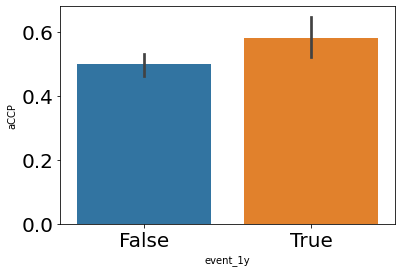

In [28]:
#df_response[df_response['event_1y']]['aCCP']
import seaborn as sns

df_response = df_response[df_response['MTX-starter']==True]
ax = sns.barplot(x="event_1y", y="aCCP", data=df_response)

#### #7.2.1 Save all survival data + baseline variables to test for clec16a variant (genetics)

In [ ]:
import pandas as pd

# Let op: dit is een beperkte lijst van EAC nummers (Vraag Samantha om een nieuwe extractie te linken!! -> to increase sample size)
df_keys = pd.read_csv('../keys/EAC_keys_2023.csv', sep=';')
#df_keys = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/EAC_keys2.csv', sep=';')
#df_keys.columns=['EACNUMM', 'PATNR'] #Identificatie_EACNUMM;member_entity_Pseudonym_value

# generate dictionary to link patient id with EAC-id
d_eac = dict(zip(df_keys.PATNR, df_keys.EACNUMM))

df_response['PATNR'] = df_response['patnr'].str[:9].astype(int)

# make a subset of the data
df_response['EACNUMM'] = df_response['PATNR'].apply(lambda x: d_eac[x] if x in d_eac.keys() else np.nan)
df_clec16a = df_response[['EACNUMM', 'patnr', 'time', 'event', 'event_1y', '', 'MTX-starter', 'Cluster', 'Age', 'Sex', 'aCCP', 'RF']].copy()
df_clec16a['pseudoId'] = df_clec16a['patnr']
df_clec16a['patnr'] = df_clec16a['patnr'].str[:9]

df_clec16a.to_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/5_clustering/df_phenograph_clusters_clec16a_NEW.csv', sep='|', index=False)

#### add replication samples

In [ ]:
df_meta2 = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/7_final/BaselinePopulation_REPLICATION.csv', sep=';') 

# Acquire EAC patients
df_eac_keys = pd.read_csv('../new_data/8_replication/EAC_patients_AllNP_Characteristics.csv', sep='|')
l_pre2011 = list(df_eac_keys['PATNR'].unique())
d_eac_keys = dict(zip(df_eac_keys['PATNR'], df_eac_keys['EACNUMM']))

df_meta2['EACNUMM'] = df_meta2['PATNR'].apply(lambda x: d_eac_keys[x])
df_meta2['Cluster'] = df_meta2['PhenoGraph_clusters'] + 1

df_meta2 = df_meta2.rename(columns = {'PATNR' : 'patnr'})
df_meta2['pseudoId'] = df_meta2['patnr'].astype(str) + '_0' 
df_meta2['REPLICATION'] = 1
df_clec16a['REPLICATION'] = 0

df_total = pd.concat([df_clec16a[['pseudoId', 'patnr','EACNUMM', 'Cluster', 'REPLICATION']], df_meta2[['pseudoId', 'patnr', 'Cluster', 'EACNUMM', 'REPLICATION']] ], ignore_index=True)
df_total.to_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/5_clustering/df_phenograph_clusters_clec16a_TOTAL.csv', sep='|', index=False)
df_total

#### #7.2.2 Save DAS & some metadata to test predictive value of initial DAS

In [7]:
df_meta = df_response[['patnr', 'pseudoId', 'time', 'event', 'event_1y', 'event_8y', 'totalFollowUp', 'MTX-starter', 'Cluster', 'Age', 'Sex', 'aCCP', 'RF', 'DAS44', 'DAS28', 'Treatment','FinalTreatment', 'Cluscat', 'Cluscat1', 'Cluscat2', 'Cluscat3', 'Cluscat4']].copy()

df_meta['patnr'] = df_meta['patnr'].str[:9]

df_meta.to_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/df_ehr_DAS.csv', sep='|', index=False)

#### Add time till treat? 

In [22]:
import pandas as pd

# Check if assocation with MTX still holds if you add time till treatment
PROJECTION_DATA = 'MMAE_clustering_270'

metadata = pd.read_csv('../new_data/7_final/%s.csv' % PROJECTION_DATA, index_col=0)
d_tillTreat = dict(zip(metadata['pseudoId'], metadata['MannTillTreat']))

df_response['MannTillTreat'] = df_response['patnr'].apply(lambda x : d_tillTreat[x])
df_response['MannTillTreat'] = df_response['MannTillTreat'].replace(-1, 0)

#### #7.2.3 Save all survival data for MTX-starters

In [5]:
df_response = df_response[df_response['MTX-starter']==True]# 'Cluscat',
df_response['diseaseDuration'] = df_response['symptomDuration'] + df_response['MannTillTreat'] 

df_response[['pseudoId', 'time', 'event', 'event_1y', 'event_8y', 'Cluster',  'Cluster1', 'Cluster2', 'Cluster3', 'Cluster4', 'Age', 'Sex', 'SJC', 'TJC', 'aCCP', 'RF', 'symptomDuration', 'diseaseDuration', 'MannTillTreat', 'MTX-starter']].to_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/5_clustering/df_survivaldata_mmae.csv')

### #7.3 Render Kaplan Meier curves

#### #7.3.1 effect of aCCP

3976.0
Patients that stay with treatment in cluster 0.0: 0.788 0
4071.0
Patients that stay with treatment in cluster 1.0: 0.730 258


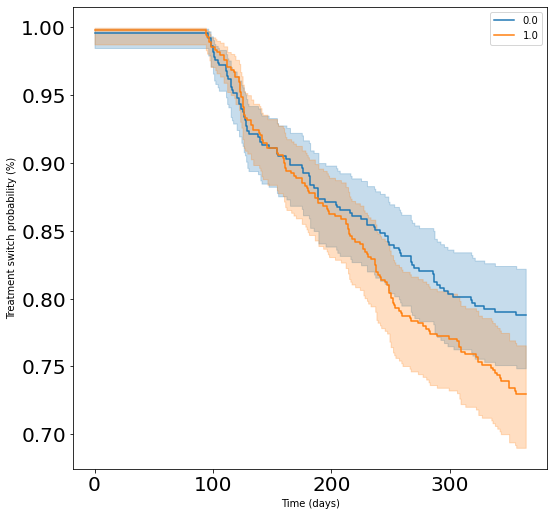

In [4]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
ax = plt.subplot(111)


df_response = df_response[df_response['MTX-starter']==True] # Subset on MTX-starters

FOLLOWUP= 365 #365+62#365+365+365#365+62#365+365 # 365+62 #365+62 3150 3150

kmf = KaplanMeierFitter() # , timeline=range(1, FOLLOWUP, 1)

fig = plt.gcf()
fig.set_size_inches(8.5, 8.5)

ix = 0

for name, grouped_df in df_response.groupby('aCCP'):
    kmf.fit(grouped_df["time"], grouped_df["event"], label=name, timeline=range(0, FOLLOWUP, 1)) # , timeline=range(0, 365+62, 1)
    kmf.plot_survival_function(ax=ax)
    print(grouped_df["time"].max())

    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Treatment switch probability (%)')

    df = kmf.event_table.copy()
    df = df.reset_index()
    
    # calculate final patients that stay with baseline by hand (positive control)
    #final = (len(df_response[((df_response['event']==True) & (df_response['Cluster']==name) & (df_response['time']>FOLLOWUP))]) + len(df_response[((df_response['event']==False) & (df_response['Cluster']==name))]))/len(df_response[((df_response['Cluster']==name))])
    #print('Patients that stay with treatment in cluster %s: %.2f' % (name, final), len(df_response[((df_response['Cluster']==name) & (df_response['time']<FOLLOWUP))]))
    print('Patients that stay with treatment in cluster %s: %.3f' % (name,kmf.survival_function_.iloc[-1].values[0]), round(kmf.survival_function_.iloc[-1].values[0]*len(df_response[((df_response['time']>=0) & (df_response['Cluster']==name) )]))) # (df_response['time']>=0) &
    ix+=1

#### #7.3.2 effect of clusters

4039.0
Patients that stay with treatment in cluster 1: 0.729 257
4071.0
Patients that stay with treatment in cluster 2: 0.772 211
4045.0
Patients that stay with treatment in cluster 3: 0.839 201
3976.0
Patients that stay with treatment in cluster 4: 0.697 152


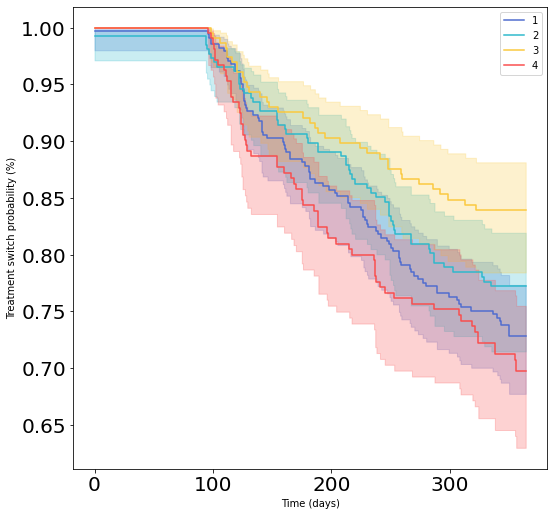

In [38]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
ax = plt.subplot(111)

pal_colorblind = ['#4F6CCF', '#2db9cc', '#FBC93D', '#FA4D4D'];
df_response = df_response[df_response['MTX-starter']==True] # Subset on MTX-starters
#df_response = df_response[((df_response['MTX-starter']==True) & df_response['Treatment'].isin(["['METHOTREXAAT', 'PREDNISOLON']","['METHOTREXAAT']"])) ]#['Treatment'].unique()
#df_response = df_response[df_response['Thresh_50%']==False] # Subset on Extreme

FOLLOWUP= 365 #365+62#365+365+365#365+62#365+365 # 365+62 #365+62 3150 3150

kmf = KaplanMeierFitter() # , timeline=range(1, FOLLOWUP, 1)

fig = plt.gcf()
fig.set_size_inches(8.5, 8.5)
ix = 0

for name, grouped_df in df_response.groupby('Cluster'):
    kmf.fit(grouped_df["time"], grouped_df["event_1y"], label=name, timeline=range(0, FOLLOWUP, 1)) # , timeline=range(0, 365+62, 1)
    kmf.plot_survival_function(ax=ax,color=pal_colorblind[ix])
    print(grouped_df["time"].max())

    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Treatment switch probability (%)')

    df = kmf.event_table.copy()
    df = df.reset_index()
    
    # calculate final patients that stay with baseline by hand (positive control)
    #final = (len(df_response[((df_response['event']==True) & (df_response['Cluster']==name) & (df_response['time']>FOLLOWUP))]) + len(df_response[((df_response['event']==False) & (df_response['Cluster']==name))]))/len(df_response[((df_response['Cluster']==name))])
    #print('Patients that stay with treatment in cluster %s: %.2f' % (name, final), len(df_response[((df_response['Cluster']==name) & (df_response['time']<FOLLOWUP))]))
    print('Patients that stay with treatment in cluster %s: %.3f' % (name,kmf.survival_function_.iloc[-1].values[0]), round(kmf.survival_function_.iloc[-1].values[0]*len(df_response[((df_response['time']>=0) & (df_response['Cluster']==name) )]))) # (df_response['time']>=0) &
    ix+=1

#### #7.3.3 Substratification on aCCP

3920.0
Patients that stay with treatment in cluster (1, 0.0): 0.827 0
No of patients: 143
4039.0
Patients that stay with treatment in cluster (1, 1.0): 0.664 0
No of patients: 211
3930.0
Patients that stay with treatment in cluster (2, 0.0): 0.791 0
No of patients: 100
4071.0
Patients that stay with treatment in cluster (2, 1.0): 0.761 0
No of patients: 175
3969.0
Patients that stay with treatment in cluster (3, 0.0): 0.813 0
No of patients: 156
4045.0
Patients that stay with treatment in cluster (3, 1.0): 0.887 0
No of patients: 84
3976.0
Patients that stay with treatment in cluster (4, 0.0): 0.710 0
No of patients: 125
3930.0
Patients that stay with treatment in cluster (4, 1.0): 0.682 0
No of patients: 93


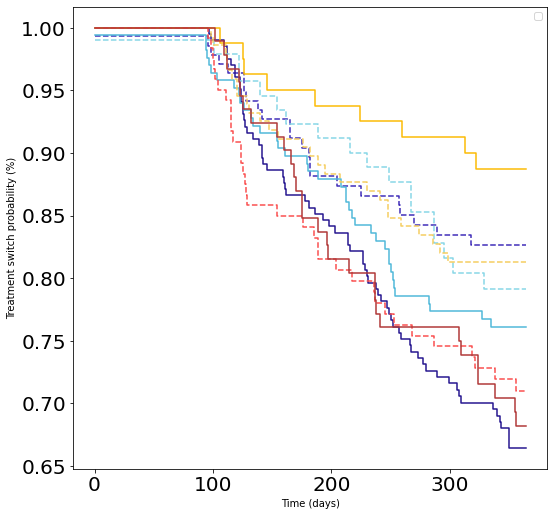

In [12]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
import matplotlib 
import seaborn as sns
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
ax = plt.subplot(111)


df_response = df_response[df_response['MTX-starter']==True] # Subset on MTX-starters

FOLLOWUP= 365 #365+62#365+365+365#365+62#365+365 # 365+62 #365+62 3150 3150

kmf = KaplanMeierFitter() # , timeline=range(1, FOLLOWUP, 1)

fig = plt.gcf()
fig.set_size_inches(8.5, 8.5)

l_pal_colorblind = ['#3d2ab8', '#24148f', '#87d6e6', '#4eb8d9',  '#f5cd5f', '#fcba03', '#FA4D4D', '#b03737',]

l_no = []
l_legend = []
l_lbl = ['C1 aCCP-', 'C1 aCCP+', 'C2 aCCP-', 'C2 aCCP+', 'C3 aCCP-', 'C3 aCCP+', 'C4 aCCP-', 'C4 aCCP+']

i = 0
for name, grouped_df in df_response.groupby(['Cluster', 'aCCP']):
    kmf.fit(grouped_df["time"], grouped_df["event_1y"], label=name, timeline=range(0, FOLLOWUP, 1)) # , timeline=range(0, 365+62, 1)
    
    if i % 2 == 0:
        linestyle='dashed' 
    else :
        linestyle='solid'
    
    kmf.plot_survival_function(ax=ax, color = l_pal_colorblind[i], ci_show=False, linestyle=linestyle) # 
    print(grouped_df["time"].max())
   

    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Treatment switch probability (%)')

    df = kmf.event_table.copy()
    df = df.reset_index()
    
    # calculate final patients that stay with baseline by hand (positive control)
    print('Patients that stay with treatment in cluster %s: %.3f' % (name,kmf.survival_function_.iloc[-1].values[0]), round(kmf.survival_function_.iloc[-1].values[0]*len(df_response[((df_response['time']>=0) & (df_response['Cluster']==name) )]))) # (df_response['time']>=0) &
    print('No of patients:', len(grouped_df))
    l_no.append(len(grouped_df))
    l_legend.append(l_lbl[i] + ' (n=%s) ' % str(len(grouped_df)))
    i += 1
    
# call method plt.legend
plt.legend([])# []

#### #7.3.4 Curves for entire followup

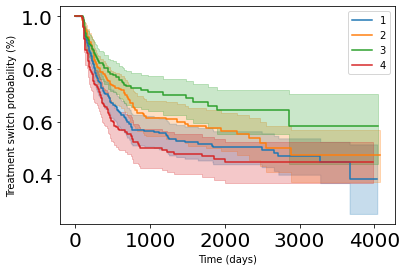

In [29]:
from collections import Counter
import matplotlib.pyplot as plt
ax = plt.subplot(111)

kmf = KaplanMeierFitter()

for name, grouped_df in df_response.groupby('Cluster'):
    kmf.fit(grouped_df[grouped_df["time"]>0]["time"], grouped_df[grouped_df["time"]>0]["event"], label=name) # , timeline=range(0, 3000, 1) timeline=range(0, 3000)
    #print(Counter(grouped_df["time"]))
    kmf.plot_survival_function(ax=ax)
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Treatment switch probability (%)')

### #7.5 Perform Cox Regression analysis

In [33]:
from lifelines import CoxPHFitter
import itertools

FOLLOWUP = 365
EVENT = 'event_1y'
N_CLUSTERS = 4
print('Follow up :', FOLLOWUP)
print('Alpha (after Bonferroni):', round(0.05/len(list(itertools.combinations(range(1,N_CLUSTERS+1), 2))), 5 ))

i = 1
for x in itertools.combinations(range(1,N_CLUSTERS+1), 2) :
    l_cluster = [x[0], x[1]]
    cph = CoxPHFitter()
    cph.fit(df_response[(df_response['Cluster'].isin(l_cluster))][['time', EVENT, 'Cluster%s' % (l_cluster[0])]], duration_col='time', event_col=EVENT)

    p_val = cph.summary['p'].values[0]
    effect = cph.summary['exp(coef)'].values[0]
    ci_lower = cph.summary['exp(coef) lower 95%'].values[0]
    ci_upper = cph.summary['exp(coef) upper 95%'].values[0]
    
    p_val = p_val #/ len(list(itertools.combinations(range(1,7), 2))) # Conservative Bonferroni Multiple testing correction
    print('Clusters %s-%s : HR:%s (%s-%s) p-val=%s ' % (x[0], x[1], round(effect,2), round(ci_lower,2), round(ci_upper,2), round(p_val,10)))
    i = i + 1 

Follow up : 365
Alpha (after Bonferroni): 0.00833
Clusters 1-2 : HR:1.21 (0.87-1.69) p-val=0.2548602254 
Clusters 1-3 : HR:1.77 (1.21-2.61) p-val=0.003642698 
Clusters 1-4 : HR:0.85 (0.62-1.18) p-val=0.3335328823 
Clusters 2-3 : HR:1.46 (0.96-2.22) p-val=0.0754153486 
Clusters 2-4 : HR:0.7 (0.49-1.01) p-val=0.0546665802 
Clusters 3-4 : HR:0.48 (0.32-0.73) p-val=0.0004813965 


/exports/reum/tdmaarseveen/convae_architecture/envs/lib/python3.8/site-packages/lifelines/utils/__init__.py:984: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  nonnumeric_cols = [col for (col, dtype) in df.dtypes.iteritems() if dtype.name == "category" or dtype.kind not in "biuf"]
/exports/reum/tdmaarseveen/convae_architecture/envs/lib/python3.8/site-packages/lifelines/utils/__init__.py:984: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  nonnumeric_cols = [col for (col, dtype) in df.dtypes.iteritems() if dtype.name == "category" or dtype.kind not in "biuf"]
/exports/reum/tdmaarseveen/convae_architecture/envs/lib/python3.8/site-packages/lifelines/utils/__init__.py:984: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  nonnumeric_cols = [col for (col, dtype) in df.dtypes.iteritems() if dtype.name == "category" or dtype.kind not 

In [9]:
'%s ~ %s * MannTillTreat' % (EVENT, 'Cluster%s' % (l_cluster[0]))

'event_1y ~ Cluster1 * MannTillTreat'

In [ ]:
cph = CoxPHFitter()
cph.fit(df_response[['time', EVENT, 'Cluster', 'MannTillTreat']], duration_col='time', event_col=EVENT, timeline=range(0, FOLLOWUP, 1), formula='EVENT ~ Cluster * MannTillTreat')


cph.plot_partial_effects_on_outcome(covariates = ['Cluster', 'MannTillTreat'], values = [[0,-1], [0,150], [0,350], [1,-1], [1,150], [1,350], [2,-1], [2,150], [2,350], [3,-1], [3,150], [3,350]], cmap = 'coolwarm')

In [ ]:
# MannTillTreat

from lifelines import CoxPHFitter
import itertools
from formulaic import Formula

FOLLOWUP = 365
EVENT = 'event_1y'
N_CLUSTERS = 4
print('Follow up :', FOLLOWUP)
print('Alpha (after Bonferroni):', round(0.05/len(list(itertools.combinations(range(1,N_CLUSTERS+1), 2))), 5 ))

i = 1
for x in itertools.combinations(range(1,N_CLUSTERS+1), 2) :
    l_cluster = [x[0], x[1]]
    cph = CoxPHFitter()
    cph.fit(df_response[(df_response['Cluster'].isin(l_cluster))][['time', EVENT, 'Cluster%s' % (l_cluster[0])]], duration_col='time', event_col=EVENT, timeline=range(0, FOLLOWUP, 1))
    # , event_col=EVENT, 
    p_val = cph.summary['p'].values[0]
    effect = cph.summary['exp(coef)'].values[0]
    ci_lower = cph.summary['exp(coef) lower 95%'].values[0]
    ci_upper = cph.summary['exp(coef) upper 95%'].values[0]
    
    p_val = p_val #/ len(list(itertools.combinations(range(1,7), 2))) # Conservative Bonferroni Multiple testing correction
    print('Clusters %s-%s : HR:%s (%s-%s) p-val=%s ' % (x[0], x[1], round(effect,2), round(ci_lower,2), round(ci_upper,2), round(p_val,10)))
    i = i + 1 

#### #7.5.1 Check assumptions with Schoenfeld residual plots

/exports/reum/tdmaarseveen/convae_architecture/envs/lib/python3.8/site-packages/lifelines/fitters/mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  for variable in self.params_.index & (columns or self.params_.index):


The ``p_value_threshold`` is set at 0.99. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



/exports/reum/tdmaarseveen/convae_architecture/envs/lib/python3.8/site-packages/lifelines/statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 1087 total observations, 840 right-censored observations>
         test_name = proportional_hazard_test

---
              test_statistic    p  -log2(p)
Cluster km              0.74 0.39      1.36
        rank            0.65 0.42      1.25



1. Variable 'Cluster' failed the non-proportional test: p-value is 0.3900.

   Advice: with so few unique values (only 4), you can include `strata=['Cluster', ...]` in the call
in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Stratification



[[<AxesSubplot:xlabel='rank-transformed time\n(p=0.4204)'>,
  <AxesSubplot:xlabel='km-transformed time\n(p=0.3900)'>]]

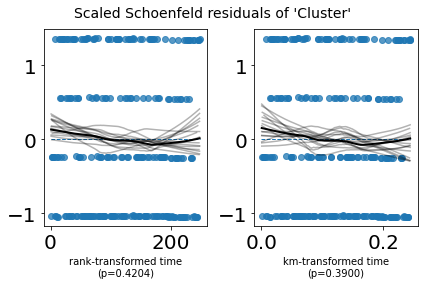

In [14]:
FOLLOWUP=365
cph = CoxPHFitter()
# ((df_response['time']<FOLLOWUP))
cph.fit(df_response[['time', 'event_1y', 'Cluster']], duration_col='time', event_col='event_1y')
cph.check_assumptions(df_response[['time', 'event_1y', 'Cluster']],  p_value_threshold=0.99, show_plots=True)

## #7.6 Check baseline characteristics of aCCP substratification

### #7.6.1 import data

In [18]:
import pandas as pd

# Import data 
df_response = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/7_final/SummaryResponseTable_MMAE3.csv', sep=';')

# Import all cluster variables
df_cluster = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/7_final/MMAE_clustering_270_Stability.csv') 

# select on mtx starters
df_response = df_response[df_response['MTX-starter']==True]

# select from cluster data on overlap with mtx starters
df_cluster = df_cluster[df_cluster['pseudoId'].isin(df_response['patnr'])]

# Get follow up
df_treat_new = pd.read_csv(r'../filters/RA_patients_AllNP_Characteristics_symptomDur.csv', sep='|')

if 'totalFollowUp' not in df_cluster.columns:
    # Get pseudoId
    df_cluster = pd.merge(df_cluster, df_treat_new[['pseudoId', 'totalFollowUp']], left_on='pseudoId', right_on='pseudoId', how='left') 

### #7.6.2 Preload baseline generation functions

In [19]:
import numpy as np 

def IQR(data):
    # First quartile (Q1)
    if len(data) > 0:
        Q1 = np.percentile(data, 25, interpolation = 'midpoint')

        # Third quartile (Q3)
        Q3 = np.percentile(data, 75, interpolation = 'midpoint')

        # Interquaritle range (IQR)
        iqr = Q3 - Q1
        return [Q1, Q3]
    else :
        return [0, 0]

def summary(lbl, df):
    """
    Calculate summary details of the provided dropped out patients
    
    - DAS
    - FollowUp
    - Symptom duration
    - MTX
    """
    #print('aCCP')
    n = len(df)
    pat = len(set(df['pseudoId'].str[:9]))
    #print(df.columns)
    #print(df['RF'].unique())
    rf = '%.0f (%.1f)' % (len(df[df['RF']==1]), (len(df[df['RF']==1])/len(df[df['RF']!=2]))*100)
    rf_neg = '%.0f (%.1f)' % (len(df[df['RF']==0]), (len(df[df['RF']==0]) /len(df[df['RF']!=2]))*100)
    rf_na = '%.0f (%.1f)' % (len(df[df['RF']==2]), (len(df[df['RF']==2])/len(df))*100)
    accp = '%.0f (%.1f)' % (len(df[df['aCCP']==1]), (len(df[df['aCCP']==1])/len(df[df['aCCP']!=2]))*100)
    accp_neg = '%.0f (%.1f)' % (len(df[df['aCCP']==0]), (len(df[df['aCCP']==0]) /len(df[df['aCCP']!=2]))*100)
    accp_na = '%.0f (%.1f)' % (len(df[df['aCCP']==2]), (len(df[df['aCCP']==2])/len(df))*100)
    sex = '%.0f (%.1f)' % (np.sum(df['Sex']), np.mean(df['Sex']) * 100)
    esr = '%.0f (%0.f-%0.f)' % (np.median(df[~df['BSE'].isna()]['BSE']), IQR(df[~df['BSE'].isna()]['BSE'])[0], IQR(df[~df['BSE'].isna()]['BSE'])[1])
    esr_na = '%.1f (%.1f)' % (len(df[df['BSE'].isna()]), (len(df[df['BSE'].isna()])/ len(df))*100)
    age = '%.1f (%.1f)' % (np.mean(df['Age']), np.std(df['Age']))
    sjc = '%.0f (%0.f-%0.f)' % (np.median(df['SJC']), IQR(df['SJC'])[0], IQR(df['SJC'])[1])
    no_sjc = '%.1f (%.1f)' % (len(df[df['SJC']==0]['SJC']), (len(df[df['SJC']==0])/ len(df))*100)
    tjc = '%.0f (%0.f-%0.f)' % (np.median(df['TJC']), IQR(df['TJC'])[0], IQR(df['TJC'])[1])
    no_tjc = '%.1f (%.1f)' % (len(df[df['TJC']==0]['TJC']), (len(df[df['TJC']==0])/ len(df))*100)
    das28 = '%.1f (%.1f-%1.1f)' % (np.median(df[~df['DAS28(3)'].isna()]['DAS28(3)']), IQR(df[~df['DAS28(3)'].isna()]['DAS28(3)'])[0], IQR(df[~df['DAS28(3)'].isna()]['DAS28(3)'])[1])
    das28_na = '%.1f (%.1f)' % (len(df[df['DAS28(3)'].isna()]['DAS28(3)']), (len(df[df['DAS28(3)'].isna()])/ len(df))*100)
    das44 = '%.1f (%.1f-%.1f)' % (np.median(df[~df['DAS44'].isna()]['DAS44']), IQR(df[~df['DAS44'].isna()]['DAS44'])[0], IQR(df[~df['DAS44'].isna()]['DAS44'])[1])
    das44_na = '%.1f (%.1f)' % (len(df[df['DAS44'].isna()]['DAS44']), (len(df[df['DAS44'].isna()])/ len(df))*100)
    #proba = '%.3f (%1.f-%1.f)' % (np.median(df['prediction']), IQR(df['prediction'])[0], IQR(df['prediction'])[1])
    #mtp = '%.0f (%0.f-%0.f)' % (np.median(df['MTP-count']), IQR(df['MTP-count'])[0], IQR(df['MTP-count'])[1])
    if 'symptomDuration' in df.columns: 
        symp = '%.0f (%0.f-%0.f)' % (np.median(df[~df['symptomDuration'].isna()]['symptomDuration']), IQR(df[~df['symptomDuration'].isna()]['symptomDuration'])[0], IQR(df[~df['symptomDuration'].isna()]['symptomDuration'])[1])
        symp_na ='%.0f (%0.f)' % (len(df[df['symptomDuration'].isna()]), (len(df[df['symptomDuration'].isna()])/ len(df))*100)
    else :
        symp = np.nan
        symp_na = np.nan
    if 'totalFollowUp' in df.columns:
        fu = '%.f (%0.f-%0.f)' % (np.median(df[~df['totalFollowUp'].isna()]['totalFollowUp']), IQR(df[~df['totalFollowUp'].isna()]['totalFollowUp'])[0], IQR(df[~df['totalFollowUp'].isna()]['totalFollowUp'])[1])
    else :
        fu = np.nan
        # DAS28(3)
    return [lbl, n, pat, sex, rf, rf_neg, rf_na, accp, accp_neg, accp_na, esr, esr_na, age, sjc, no_sjc, tjc, no_tjc, das28, das28_na, das44, das44_na, 1, symp, symp_na, fu]
   

### #7.6.3. Show overview for all clusters

#### Cluster 1 

In [20]:
l_col = ['id', 'N', 'Pat', 'Sex [n(%)]', 'RF+ [n(%)]', 'ESR (median+-IQR, mm/hr)', 'Age (mean+-SD, yr)', 'SJC (median+-IQR)', 'TJC (median+-IQR)',  'DAS28(3) (median+-IQR)',  'DAS44 (median+-IQR)', 'Symptom duration', 'Follow-up']
df_baseline = pd.DataFrame(columns=['id', 'N', 'Pat', 'Sex [n(%)]', 'RF+ [n(%)]', 'RF- [n(%)]', 'RF_NA [n(%)]', 'aCCP+ [n(%)]', 'aCCP- [n(%)]', 'aCCP_NA [n(%)]', 'ESR (median+-IQR, mm/hr)', 'ESR_NA [n(%)]', 'Age (mean+-SD, yr)', 'SJC (median+-IQR)', 'NO_Swollen[n(%)]', 'TJC (median+-IQR)', 'NO_Tender [n(%)]', 'DAS28(3) (median+-IQR)', 'DAS28(3)_NA [n(%)]', 'DAS44 (median+-IQR)', 'DAS44_NA [n(%)]', 'probability', 'Symptom duration', 'Symptom duration NA [n(%)]', 'Follow-up'])
df_baseline.loc[len(df_baseline)] = summary('C1 aCCP+', df_cluster[((df_cluster['PhenoGraph_clusters']==0) & (df_cluster['aCCP']==1))])
df_baseline.loc[len(df_baseline)] = summary('C1 aCCP-', df_cluster[((df_cluster['PhenoGraph_clusters']==0) & (df_cluster['aCCP']==0))])
df_baseline = df_baseline[l_col]
df_baseline = df_baseline.set_index('id')
df_baseline.T

id,C1 aCCP+,C1 aCCP-
N,211,143
Pat,209,140
Sex [n(%)],135 (64.0),89 (62.2)
RF+ [n(%)],184 (87.2),33 (23.1)
"ESR (median+-IQR, mm/hr)",22 (11-36),22 (9-37)
"Age (mean+-SD, yr)",56.8 (12.1),58.2 (15.3)
SJC (median+-IQR),8 (5-11),9 (6-12)
TJC (median+-IQR),11 (9-15),12 (8-16)
DAS28(3) (median+-IQR),5.3 (4.6-6.0),5.4 (4.5-6.1)
DAS44 (median+-IQR),3.6 (3.0-4.0),3.6 (3.1-4.1)


#### Cluster 2

In [21]:
l_col = ['id', 'N', 'Pat', 'Sex [n(%)]', 'RF+ [n(%)]', 'ESR (median+-IQR, mm/hr)', 'Age (mean+-SD, yr)', 'SJC (median+-IQR)', 'TJC (median+-IQR)',  'DAS28(3) (median+-IQR)',  'DAS44 (median+-IQR)', 'Symptom duration', 'Follow-up']
df_baseline = pd.DataFrame(columns=['id', 'N', 'Pat', 'Sex [n(%)]', 'RF+ [n(%)]', 'RF- [n(%)]', 'RF_NA [n(%)]', 'aCCP+ [n(%)]', 'aCCP- [n(%)]', 'aCCP_NA [n(%)]', 'ESR (median+-IQR, mm/hr)', 'ESR_NA [n(%)]', 'Age (mean+-SD, yr)', 'SJC (median+-IQR)', 'NO_Swollen[n(%)]', 'TJC (median+-IQR)', 'NO_Tender [n(%)]', 'DAS28(3) (median+-IQR)', 'DAS28(3)_NA [n(%)]', 'DAS44 (median+-IQR)', 'DAS44_NA [n(%)]', 'probability', 'Symptom duration', 'Symptom duration NA [n(%)]', 'Follow-up'])
df_baseline.loc[len(df_baseline)] = summary('C2 aCCP+', df_cluster[((df_cluster['PhenoGraph_clusters']==1) & (df_cluster['aCCP']==1))])
df_baseline.loc[len(df_baseline)] = summary('C2 aCCP-', df_cluster[((df_cluster['PhenoGraph_clusters']==1) & (df_cluster['aCCP']==0))])
df_baseline = df_baseline[l_col]
df_baseline = df_baseline.set_index('id')
df_baseline.T

id,C2 aCCP+,C2 aCCP-
N,175,100
Pat,174,99
Sex [n(%)],129 (73.7),66 (66.0)
RF+ [n(%)],157 (89.7),27 (27.0)
"ESR (median+-IQR, mm/hr)",31 (17-46),22 (11-39)
"Age (mean+-SD, yr)",58.5 (14.4),59.4 (14.0)
SJC (median+-IQR),3 (1-4),3 (1-4)
TJC (median+-IQR),3 (1-5),4 (2-6)
DAS28(3) (median+-IQR),4.3 (3.5-4.8),4.1 (3.4-4.7)
DAS44 (median+-IQR),2.5 (2.0-2.8),2.5 (2.0-2.8)


#### Cluster 3 

In [22]:
l_col = ['id', 'N', 'Pat', 'Sex [n(%)]', 'RF+ [n(%)]', 'ESR (median+-IQR, mm/hr)', 'Age (mean+-SD, yr)', 'SJC (median+-IQR)', 'TJC (median+-IQR)',  'DAS28(3) (median+-IQR)',  'DAS44 (median+-IQR)', 'Symptom duration', 'Follow-up']
df_baseline = pd.DataFrame(columns=['id', 'N', 'Pat', 'Sex [n(%)]', 'RF+ [n(%)]', 'RF- [n(%)]', 'RF_NA [n(%)]', 'aCCP+ [n(%)]', 'aCCP- [n(%)]', 'aCCP_NA [n(%)]', 'ESR (median+-IQR, mm/hr)', 'ESR_NA [n(%)]', 'Age (mean+-SD, yr)', 'SJC (median+-IQR)', 'NO_Swollen[n(%)]', 'TJC (median+-IQR)', 'NO_Tender [n(%)]', 'DAS28(3) (median+-IQR)', 'DAS28(3)_NA [n(%)]', 'DAS44 (median+-IQR)', 'DAS44_NA [n(%)]', 'probability', 'Symptom duration', 'Symptom duration NA [n(%)]', 'Follow-up'])
df_baseline.loc[len(df_baseline)] = summary('C3 aCCP+', df_cluster[((df_cluster['PhenoGraph_clusters']==2) & (df_cluster['aCCP']==1))])
df_baseline.loc[len(df_baseline)] = summary('C3 aCCP-', df_cluster[((df_cluster['PhenoGraph_clusters']==2) & (df_cluster['aCCP']==0))])
df_baseline = df_baseline[l_col]
df_baseline = df_baseline.set_index('id')
df_baseline.T

id,C3 aCCP+,C3 aCCP-
N,84,156
Pat,83,154
Sex [n(%)],52 (61.9),97 (62.2)
RF+ [n(%)],71 (84.5),29 (18.6)
"ESR (median+-IQR, mm/hr)",30 (18-56),29 (14-48)
"Age (mean+-SD, yr)",67.4 (13.1),67.4 (11.6)
SJC (median+-IQR),9 (6-14),10 (7-15)
TJC (median+-IQR),10 (7-14),12 (8-16)
DAS28(3) (median+-IQR),5.4 (4.9-6.4),5.7 (5.0-6.3)
DAS44 (median+-IQR),3.5 (3.1-4.4),3.9 (3.3-4.3)


#### Cluster 4

In [23]:
l_col = ['id', 'N', 'Pat', 'Sex [n(%)]', 'RF+ [n(%)]', 'ESR (median+-IQR, mm/hr)', 'Age (mean+-SD, yr)', 'SJC (median+-IQR)', 'TJC (median+-IQR)',  'DAS28(3) (median+-IQR)',  'DAS44 (median+-IQR)', 'Symptom duration', 'Follow-up']
df_baseline = pd.DataFrame(columns=['id', 'N', 'Pat', 'Sex [n(%)]', 'RF+ [n(%)]', 'RF- [n(%)]', 'RF_NA [n(%)]', 'aCCP+ [n(%)]', 'aCCP- [n(%)]', 'aCCP_NA [n(%)]', 'ESR (median+-IQR, mm/hr)', 'ESR_NA [n(%)]', 'Age (mean+-SD, yr)', 'SJC (median+-IQR)', 'NO_Swollen[n(%)]', 'TJC (median+-IQR)', 'NO_Tender [n(%)]', 'DAS28(3) (median+-IQR)', 'DAS28(3)_NA [n(%)]', 'DAS44 (median+-IQR)', 'DAS44_NA [n(%)]', 'probability', 'Symptom duration', 'Symptom duration NA [n(%)]', 'Follow-up'])
df_baseline.loc[len(df_baseline)] = summary('C4 aCCP+', df_cluster[((df_cluster['PhenoGraph_clusters']==3) & (df_cluster['aCCP']==1))])
df_baseline.loc[len(df_baseline)] = summary('C4 aCCP-', df_cluster[((df_cluster['PhenoGraph_clusters']==3) & (df_cluster['aCCP']==0))])
df_baseline = df_baseline[l_col]
df_baseline = df_baseline.set_index('id')
df_baseline.T

id,C4 aCCP+,C4 aCCP-
N,93,125
Pat,92,122
Sex [n(%)],53 (57.0),77 (61.6)
RF+ [n(%)],75 (80.6),18 (14.4)
"ESR (median+-IQR, mm/hr)",28 (9-41),19 (9-41)
"Age (mean+-SD, yr)",54.2 (14.0),56.6 (15.2)
SJC (median+-IQR),14 (10-21),15 (9-22)
TJC (median+-IQR),22 (17-29),25 (18-33)
DAS28(3) (median+-IQR),6.6 (5.6-7.5),6.7 (5.6-7.3)
DAS44 (median+-IQR),4.8 (4.0-5.7),4.7 (4.1-5.5)


## #7.7 Check if our clusters are better than random

In [ ]:
from lifelines import CoxPHFitter
import itertools
import warnings

l_p = []

np.random.seed(1234)

FOLLOWUP = 365
EVENT = 'event_1y'
N_CLUSTERS = 4
print('Follow up :', FOLLOWUP)
print('Alpha (after Bonferroni):', round(0.05/len(list(itertools.combinations(range(1,N_CLUSTERS+1), 2))), 5 ))

for i in range(1000): 
    df_response['Cluster_rand'] = np.random.choice(4, len(df_response))
    df_response['Cluster_rand'] = df_response['Cluster_rand'] + 1
    # create dummy variables
    just_dummies = pd.get_dummies(df_response['Cluster_rand'])

    df_sub = pd.concat([df_response, just_dummies], axis=1)   
    df_sub = df_sub.rename(columns={1: 'Cluster_rand1', 2: 'Cluster_rand2', 3: 'Cluster_rand3', 4: 'Cluster_rand4'})
    smallest_p_val = 1
    for x in itertools.combinations(range(1,N_CLUSTERS+1), 2) :
        #print()
        l_cluster = [x[0], x[1]]
        cph = CoxPHFitter()
        #print(l_cluster)
        with warnings.catch_warnings():
            # ignore all caught warnings
            warnings.filterwarnings("ignore")
            cph.fit(df_sub[(df_sub['Cluster_rand'].isin(l_cluster))][['time', EVENT, 'Cluster_rand%s' % (l_cluster[0])]], duration_col='time', event_col=EVENT)

        p_val = cph.summary['p'].values[0]
        effect = cph.summary['exp(coef)'].values[0]
        ci_lower = cph.summary['exp(coef) lower 95%'].values[0]
        ci_upper = cph.summary['exp(coef) upper 95%'].values[0]
        
        if p_val < smallest_p_val:
            smallest_p_val = p_val 
    l_p.append(smallest_p_val)

In [41]:
min(l_p)

0.0003273892130913681

/exports/reum/tdmaarseveen/convae_architecture/envs/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

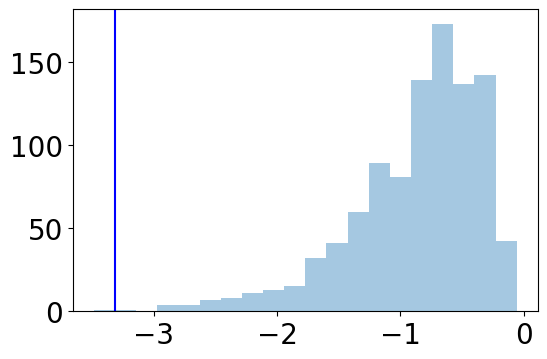

In [42]:
import seaborn as sns


f = plt.figure(figsize=(6,4), dpi=100)
# only one line may be specified; full height
plt.axvline(x = np.log10(0.0004813965), color = 'b', label = 'axvline - full height')

sns.distplot(np.log10(l_p), kde=False, hist=True,  bins=20, label='Random')

#### There is only 1 random clustering that shows a stronger assocation with the outcome 
That is actually a good sign : 1 / 1000 = 0.1% 

In [62]:
np.array(l_p)[np.array(l_p) < 0.0004813965]

array([0.00032739])

In [26]:
f = plt.figure(figsize=(6,4), dpi=100)
# only one line may be specified; full height
plt.axvline(x = 0.0004813965, color = 'b', label = 'axvline - full height')

sns.distplot(l_p, kde=False, hist=True,  bins=10, label='Random')

0.0004813965

## #7.8 Survival analysis with remission
Note: only for those overlapping with EAC 

In [ ]:
import pandas as pd
# Link EAC to MMAE table
df_eac_link = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/keys/EAC_keys_2023.csv', sep=';')
df_response = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/7_final/SummaryResponseTable_MMAE3.csv', sep=';') # SummaryResponseTable_maui_4 SummaryResponseTable2= MOFA,
df_response['Cluster'] = df_response['Cluster'] + 1

d_keys_eac = dict(zip(df_eac_link['patnr'], df_eac_link['EACNUMM']))
df_response['PATNR'] = df_response['patnr'].str[:9]
df_response['PATNR'] = df_response['PATNR'].astype(int)
df_response['EACNUMM'] = df_response['PATNR'].apply(lambda x : d_keys_eac[x])

# Apply Analysis file
df_eac= pd.read_spss('../new_data/8_replication/Analysefile_201808.sav')
df_eac['DAT1EBEZ'] = pd.to_datetime(df_eac['DAT1EBEZ'], format='%Y-%m-%d')

# Define columns of interest
l_col_remission = ['EACNUMM', 'geslacht', 'remissie', 'DAT1EBEZ', 'Visitestoppen']
l_col_remission.extend([col for col in df_eac.columns if '.bezdat' in col])
l_col_remission.extend([col for col in df_eac.columns if '.DAS44' in col] )

df_remission = df_response.merge(df_eac[l_col_remission], on='EACNUMM', how='left')

# create dummy variables
just_dummies = pd.get_dummies(df_response['Cluster'])
df_response = pd.concat([df_response, just_dummies], axis=1)   
df_response = df_response.rename(columns={1: 'Cluster1', 2: 'Cluster2', 3: 'Cluster3', 4: 'Cluster4', 5: 'Cluster5', 6: 'Cluster6'})



df_eac[l_col_remission]

Text(0.5, 1.0, 'EAC-ids Development set (HIX)')

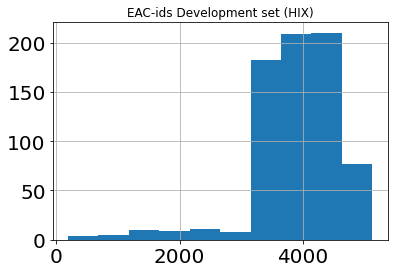

In [12]:
plt  =df_response['EACNUMM'].hist()
plt.set_title('EAC-ids Development set (HIX)')

### #7.8.1 Process data of EAC subset in Set A

In [13]:
# look for the max values in each row
import math
l_col_das = [col for col in df_eac.columns if '.DAS44' in col]

# Get date of first mannequin
df_initial = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/5_clustering/df_metadata.csv')#['pseudoId']
df_initial['firstMannequin'] = pd.to_datetime(df_initial['firstMannequin'], format='%Y-%m-%d')
d_firstMan = dict(zip(df_initial['pseudoId'], df_initial['firstMannequin']))

rms = df_remission[l_col_das].lt(1.6, axis=1)
df_remission['Remission'] = rms.dot(rms.columns + ', ').str.split(',')
df_remission['first_Remission'] = df_remission['Remission'].apply(lambda x : x[0])
df_remission['firstMannequin'] = df_remission['pseudoId'].apply(lambda x : d_firstMan[x])
df_remission['Visitestoppen'] = df_remission['Visitestoppen'].replace(99,float('nan'))
df_remission['lastVisit'] = df_remission.apply(lambda x : x['rn%s.bezdat' % (int(x['Visitestoppen']))] if math.isnan(x['Visitestoppen']) == False else np.nan, axis=1)

# Calculate nr of days (follow up and time to reach remission)
df_remission['time_Rem'] = df_remission.apply(lambda x : x['%s.bezdat' % (x['first_Remission'].split('.')[0])] if x['first_Remission'] != '' else np.nan, axis=1)
df_remission['time_Rem'] = pd.to_datetime(df_remission['time_Rem'], format='%Y-%m-%d')
df_remission['lastVisit'] = pd.to_datetime(df_remission['lastVisit'], format='%Y-%m-%d')
df_remission['calc_followUp'] = df_remission['lastVisit'] -  df_remission['firstMannequin'] 
df_remission['time_till_Rem'] = df_remission['time_Rem'] -  df_remission['firstMannequin'] 

df_remission['calc_followUp'] = df_remission['calc_followUp'].dt.days 
df_remission['time_till_Rem'] = df_remission['time_till_Rem'].dt.days

# Get followup from response as default!
d_firstFU = dict(zip(df_response['pseudoId'], df_response['totalFollowUp']))
d_firstFU

df_remission['followUp'] = df_remission['pseudoId'].apply(lambda x : d_firstFU[x])

# Fill any missing follow up -> with the calculated one or the time till Remission.
df_remission['followUp'] = df_remission['followUp'].fillna(df_remission['calc_followUp']) 
df_remission['followUp'] = df_remission['followUp'].fillna(df_remission['FollowUp']) 
df_remission['followUp'] = df_remission['followUp'].fillna(df_remission['time_till_Rem'])

df_remission['event_Rem'] = (~ df_remission['time_till_Rem'].isna()).astype(int)
df_remission['event_1y_Rem'] = (df_remission['time_till_Rem'] < 366).astype(int)
df_remission['time_till_Rem']= df_remission['time_till_Rem'].fillna(df_remission['followUp']) 
df_remission['time_till_Rem']= df_remission['time_till_Rem'].fillna(df_remission['FollowUp'])
df_subEAC = df_remission[~df_remission['EACNUMM'].isna()].copy()

# create dummy variables
just_dummies = pd.get_dummies(df_subEAC['Cluster'])

df_subEAC = pd.concat([df_subEAC, just_dummies], axis=1)   
df_subEAC = df_subEAC.rename(columns={1: 'Cluster1', 2: 'Cluster2', 3: 'Cluster3', 4: 'Cluster4', 5: 'Cluster5', 6: 'Cluster6'})

# export survival data
df_subEAC[['pseudoId', 'time_till_Rem', 'event_1y_Rem', 'event_Rem', 'Cluster',  'Cluster1', 'Cluster2', 'Cluster3', 'Cluster4', 'Age', 'Sex']].to_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/5_clustering/df_survivaldata_mmae_Remission.csv')

# export for prediction model
df_subEAC['patnr'] = df_subEAC['pseudoId'].str[:9]
df_subEAC[['patnr', 'pseudoId', 'time_till_Rem', 'event_Rem', 'event_1y_Rem','totalFollowUp', 'MTX-starter', 'Cluster', 'Cluster1', 'Cluster2', 'Cluster3', 'Cluster4', 'Age', 'Sex', 'aCCP', 'RF', 'DAS44', 'DAS28', 'SJC', 'TJC', 'BSE','Treatment','FinalTreatment']].to_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/df_ehr_REMISSION.csv', sep='|', index=False)

In [14]:
df_subEAC['patnr'] = df_subEAC['pseudoId'].str[:9]
df_subEAC[['patnr', 'pseudoId', 'time_till_Rem', 'event_Rem', 'event_1y_Rem','totalFollowUp', 'MTX-starter', 'Cluster', 'Cluster1', 'Cluster2', 'Cluster3', 'Cluster4', 'Age', 'Sex', 'aCCP', 'RF', 'DAS44', 'DAS28', 'SJC', 'TJC', 'BSE','Treatment','FinalTreatment']].to_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/df_ehr_REMISSION.csv', sep='|', index=False)

### #7.8.2 Check for bias

#### Check if rates of missingness are similar across clusters (otherwise results might be confouded)

In [ ]:
import matplotlib.pyplot as plt
grouped = df_subEAC.groupby('Cluster')[['rn1.DAS44', 'rn2.DAS44', 'rn3.DAS44', 'rn4.DAS44']]

nan_prevalence = grouped.apply(lambda x: x.isna().mean())

# Transpose the DataFrame to have columns as groups and rows as columns
nan_prevalence = nan_prevalence.T

# Plot the line plot
nan_prevalence.plot(kind='line', marker='o')

# Set plot title and axes labels
plt.title('Prevalence of NaN Values Over Time')
plt.xlabel('Columns')
plt.xticks(rotation=90)
plt.ylabel('Prevalence of NaN')

# Show the plot
plt.show()

### #7.8.3 Draw kaplan meier curves for remission

4045.0
Patients that stay with treatment in cluster 1: 0.590 123
3792.0
Patients that stay with treatment in cluster 2: 0.544 67
4045.0
Patients that stay with treatment in cluster 3: 0.477 79
3976.0
Patients that stay with treatment in cluster 4: 0.661 119


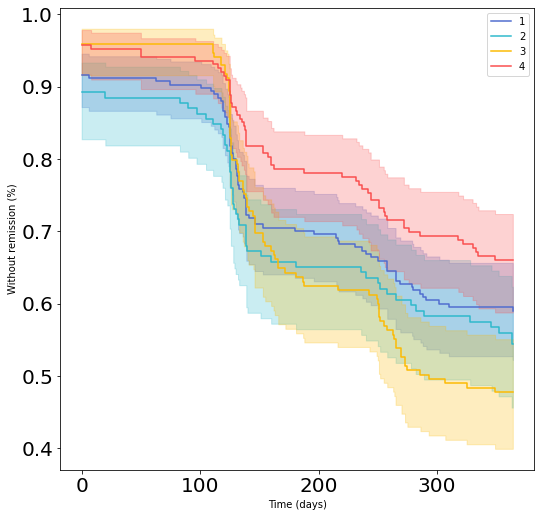

In [32]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
ax = plt.subplot(111)

df_subEAC2 = df_subEAC.copy()

FOLLOWUP= 365 #365+62#365+365+365#365+62#365+365 # 365+62 #365+62 3150 3150

pal_colorblind = ['#4F6CCF', '#2db9cc', '#fcba03', '#FA4D4D',   "#7a4da4", "#a67c73", "#FF0000FF", "#CCFF00FF", "#49BA2B", "#0066FFFF", "#CC00FFFF", '#FF9595'];

kmf = KaplanMeierFitter() # , timeline=range(1, FOLLOWUP, 1)

fig = plt.gcf()
fig.set_size_inches(8.5, 8.5)
ix = 0

for name, grouped_df in df_subEAC2.groupby('Cluster'):
    kmf.fit(grouped_df["time_till_Rem"], grouped_df["event_Rem"], label=name, timeline=range(0, FOLLOWUP, 1)) # , timeline=range(0, 365+62, 1)
    kmf.plot_survival_function(ax=ax, color=pal_colorblind[ix])
    print(grouped_df["time_till_Rem"].max())

    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Without remission (%)')

    df = kmf.event_table.copy()
    df = df.reset_index()
    
    # calculate final patients that stay with baseline by hand (positive control)
    #final = (len(df_response[((df_response['event']==True) & (df_response['Cluster']==name) & (df_response['time']>FOLLOWUP))]) + len(df_response[((df_response['event']==False) & (df_response['Cluster']==name))]))/len(df_response[((df_response['Cluster']==name))])
    #print('Patients that stay with treatment in cluster %s: %.2f' % (name, final), len(df_response[((df_response['Cluster']==name) & (df_response['time']<FOLLOWUP))]))
    print('Patients that stay with treatment in cluster %s: %.3f' % (name,kmf.survival_function_.iloc[-1].values[0]), round(kmf.survival_function_.iloc[-1].values[0]*len(df_subEAC2[((df_subEAC2['time_till_Rem']>=0) & (df_subEAC2['Cluster']==name) )]))) # (df_response['time']>=0) &
    ix +=1 
    

#### #7.8.3.2 Substratify on aCCP

3976.0
Patients that stay with treatment in cluster 0.0: 0.546 0
4045.0
Patients that stay with treatment in cluster 1.0: 0.606 126


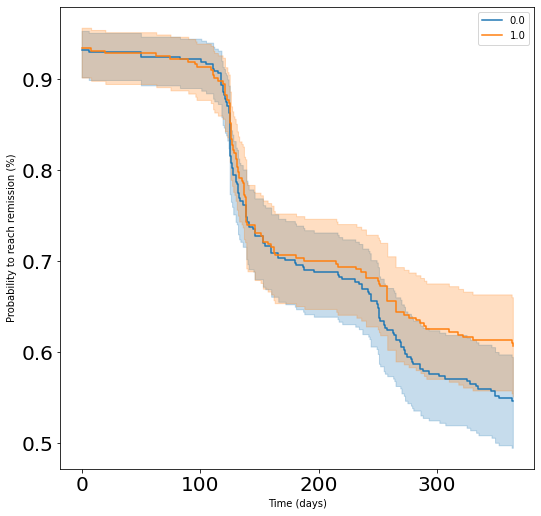

In [7]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
ax = plt.subplot(111)


FOLLOWUP= 365 

kmf = KaplanMeierFitter() 

fig = plt.gcf()
fig.set_size_inches(8.5, 8.5)

for name, grouped_df in df_subEAC.groupby('aCCP'):
    kmf.fit(grouped_df["time_till_Rem"], grouped_df["event_Rem"], label=name, timeline=range(0, FOLLOWUP, 1)) # , timeline=range(0, 365+62, 1)
    kmf.plot_survival_function(ax=ax)
    print(grouped_df["time_till_Rem"].max())

    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Without remission (%)')

    df = kmf.event_table.copy()
    df = df.reset_index()
    
    # calculate final patients that stay with baseline by hand (positive control)
    print('Patients that stay with treatment in cluster %s: %.3f' % (name,kmf.survival_function_.iloc[-1].values[0]), round(kmf.survival_function_.iloc[-1].values[0]*len(df_subEAC[((df_subEAC['time_till_Rem']>=0) & (df_subEAC['Cluster']==name) )]))) # (df_response['time']>=0) &


3161.0
Patients that stay with treatment in cluster (1, 0.0): 0.561 0
No of patients: 97
4045.0
Patients that stay with treatment in cluster (1, 1.0): 0.613 0
No of patients: 130
3664.0
Patients that stay with treatment in cluster (2, 0.0): 0.497 0
No of patients: 60
3792.0
Patients that stay with treatment in cluster (2, 1.0): 0.578 0
No of patients: 79
3941.0
Patients that stay with treatment in cluster (3, 0.0): 0.440 0
No of patients: 129
4045.0
Patients that stay with treatment in cluster (3, 1.0): 0.591 0
No of patients: 42
3976.0
Patients that stay with treatment in cluster (4, 0.0): 0.685 0
No of patients: 107
3930.0
Patients that stay with treatment in cluster (4, 1.0): 0.630 0
No of patients: 81


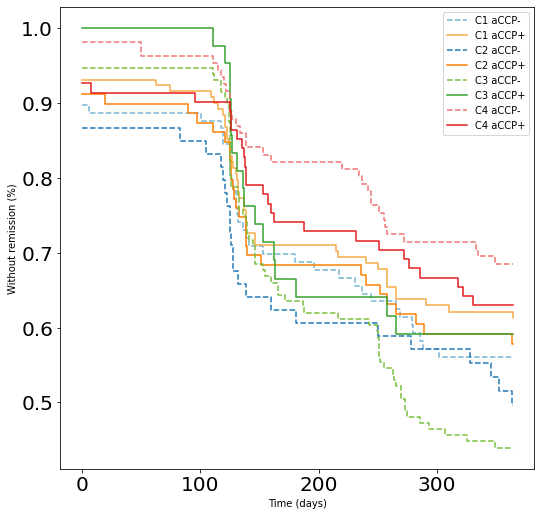

In [33]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
import matplotlib 
import seaborn as sns
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
ax = plt.subplot(111)


#df_response = df_response[df_response['MTX-starter']==True] # Subset on MTX-starters

FOLLOWUP= 365 #365+62#365+365+365#365+62#365+365 # 365+62 #365+62 3150 3150

kmf = KaplanMeierFitter() # , timeline=range(1, FOLLOWUP, 1)

fig = plt.gcf()
fig.set_size_inches(8.5, 8.5)


#palette = list(sns.color_palette("Paired").as_hex())
l_pal = ['#77b4d4', '#1f78b4', '#f7aa45', '#ff7f00', '#79bd3c',  '#33a02c', '#f07271', '#e31a1c']



i = 0
for name, grouped_df in df_subEAC.groupby(['Cluster', 'aCCP']):
    kmf.fit(grouped_df["time_till_Rem"], grouped_df["event_Rem"], label=name, timeline=range(0, FOLLOWUP, 1)) # , timeline=range(0, 365+62, 1)
    
    if i % 2 == 0:
        linestyle='dashed' 
    else :
        linestyle='solid'
    
    kmf.plot_survival_function(ax=ax, color = l_pal[i], ci_show=False, linestyle=linestyle) # 
    print(grouped_df["time_till_Rem"].max())
   

    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Without remission (%)')

    df = kmf.event_table.copy()
    df = df.reset_index()
    
    # calculate final patients that stay with baseline by hand (positive control)
    print('Patients that stay with treatment in cluster %s: %.3f' % (name,kmf.survival_function_.iloc[-1].values[0]), round(kmf.survival_function_.iloc[-1].values[0]*len(df_subEAC[((df_subEAC['time_till_Rem']>=0) & (df_subEAC['Cluster']==name) )]))) # (df_response['time']>=0) &
    print('No of patients:', len(grouped_df))
    i += 1
    
# call method plt.legend
plt.legend(['C1 aCCP-', 'C1 aCCP+', 'C2 aCCP-', 'C2 aCCP+', 'C3 aCCP-', 'C3 aCCP+', 'C4 aCCP-', 'C4 aCCP+'])

#### #7.8.3.3 Create cumulative incidence plot

4045.0
3792.0
4045.0
3976.0


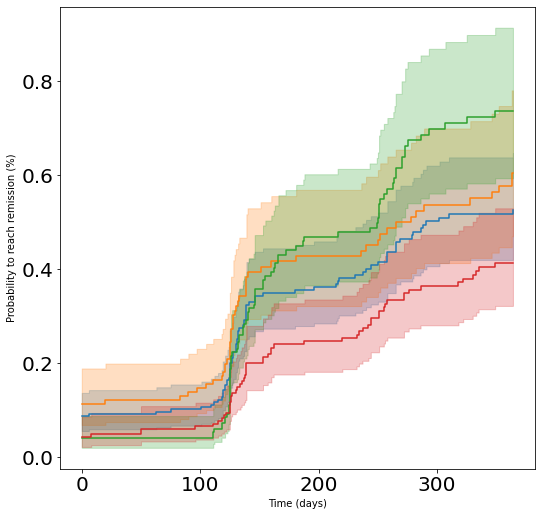

In [12]:
import matplotlib.pyplot as plt
from lifelines import NelsonAalenFitter 
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
ax = plt.subplot(111)


#df_response = df_response[df_response['MTX-starter']==True] # Subset on MTX-starters

FOLLOWUP= 365 #365+62#365+365+365#365+62#365+365 # 365+62 #365+62 3150 3150

kmf = NelsonAalenFitter() # , timeline=range(1, FOLLOWUP, 1)

fig = plt.gcf()
fig.set_size_inches(8.5, 8.5)

for name, grouped_df in df_subEAC.groupby('Cluster'):
    kmf.fit(grouped_df["time_till_Rem"], grouped_df["event_Rem"], label=name, timeline=range(0, FOLLOWUP, 1)) # , timeline=range(0, 365+62, 1)
    kmf.plot_cumulative_hazard(ax=ax, legend=None)
    print(grouped_df["time_till_Rem"].max())

    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Probability to reach remission (%)')

    df = kmf.event_table.copy()
    df = df.reset_index()
    
    # calculate final patients that stay with baseline by hand (positive control)
    #final = (len(df_response[((df_response['event']==True) & (df_response['Cluster']==name) & (df_response['time']>FOLLOWUP))]) + len(df_response[((df_response['event']==False) & (df_response['Cluster']==name))]))/len(df_response[((df_response['Cluster']==name))])
    #print('Patients that stay with treatment in cluster %s: %.2f' % (name, final), len(df_response[((df_response['Cluster']==name) & (df_response['time']<FOLLOWUP))]))
    #print('Patients that stay with treatment in cluster %s: %.3f' % (name,kmf.survival_function_.iloc[-1].values[0]), round(kmf.survival_function_.iloc[-1].values[0]*len(df_subEAC[((df_subEAC['time_till_Rem']>=0) & (df_subEAC['Cluster']==name) )]))) # (df_response['time']>=0) &


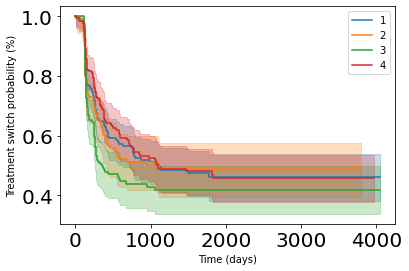

In [37]:
from collections import Counter
import matplotlib.pyplot as plt
ax = plt.subplot(111)

kmf = KaplanMeierFitter()

for name, grouped_df in df_subEAC.groupby('Cluster'):
    kmf.fit(grouped_df[grouped_df["time_till_Rem"]>0]["time_till_Rem"], grouped_df[grouped_df["time_till_Rem"]>0]["event_Rem"], label=name) # , timeline=range(0, 3000, 1) timeline=range(0, 3000)
    #print(Counter(grouped_df["time"]))
    kmf.plot_survival_function(ax=ax)
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Treatment switch probability (%)')

In [33]:
from lifelines import CoxPHFitter
import itertools

FOLLOWUP = 365
EVENT = 'event_1y_Rem'
N_CLUSTERS = 4
print('Follow up :', FOLLOWUP)
print('Alpha (after Bonferroni):', round(0.05/len(list(itertools.combinations(range(1,N_CLUSTERS+1), 2))), 5 ))

i = 1
for x in itertools.combinations(range(1,N_CLUSTERS+1), 2) :
    #print()
    l_cluster = [x[0], x[1]]
    cph = CoxPHFitter()
    #print(l_cluster)
    #print(df_response[((df_response['time']<FOLLOWUP) & (df_response['time']>=0) & (df_response['Cluster'].isin(l_cluster)))])
    cph.fit(df_subEAC[(df_subEAC['Cluster'].isin(l_cluster))][['time_till_Rem', EVENT, 'Cluster%s' % (l_cluster[0])]], duration_col='time_till_Rem', event_col=EVENT)

    p_val = cph.summary['p'].values[0]
    #print(p_val)
    effect = cph.summary['exp(coef)'].values[0]
    ci_lower = cph.summary['exp(coef) lower 95%'].values[0]
    ci_upper = cph.summary['exp(coef) upper 95%'].values[0]
    
    p_val = p_val #/ len(list(itertools.combinations(range(1,7), 2))) # Conservative Bonferroni Multiple testing correction
    print('Clusters %s-%s : HR:%s (%s-%s) p-val=%s ' % (x[0], x[1], round(effect,2), round(ci_lower,2), round(ci_upper,2), round(p_val,10)))
    i = i + 1 

Follow up : 365
Alpha (after Bonferroni): 0.00833
Clusters 1-2 : HR:0.86 (0.62-1.18) p-val=0.350619778 
Clusters 1-3 : HR:0.77 (0.57-1.03) p-val=0.0774608379 
Clusters 1-4 : HR:1.32 (0.96-1.82) p-val=0.0888048476 
Clusters 2-3 : HR:0.89 (0.64-1.24) p-val=0.4954634063 
Clusters 2-4 : HR:1.54 (1.08-2.18) p-val=0.0164774379 
Clusters 3-4 : HR:1.76 (1.27-2.44) p-val=0.0006487222 


/exports/reum/tdmaarseveen/convae_architecture/envs/lib/python3.8/site-packages/lifelines/utils/__init__.py:984: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  nonnumeric_cols = [col for (col, dtype) in df.dtypes.iteritems() if dtype.name == "category" or dtype.kind not in "biuf"]
/exports/reum/tdmaarseveen/convae_architecture/envs/lib/python3.8/site-packages/lifelines/utils/__init__.py:984: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  nonnumeric_cols = [col for (col, dtype) in df.dtypes.iteritems() if dtype.name == "category" or dtype.kind not in "biuf"]
/exports/reum/tdmaarseveen/convae_architecture/envs/lib/python3.8/site-packages/lifelines/utils/__init__.py:984: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  nonnumeric_cols = [col for (col, dtype) in df.dtypes.iteritems() if dtype.name == "category" or dtype.kind not 

## Sensitivity analysis (see notebook 5. step 5.8)
####  select only most extreme patients to see if association with treatmetn response is stronger

In [ ]:
# Only select most extreme???
df_cutoff = pd.read_csv('../new_data/7_final/MMAE_clustering_270_percCutoff.csv', index_col=0)
d_cutoff = dict(zip(df_cutoff['pseudoId'], df_cutoff['Thresh_50%']))
df_response['Thresh_50%'] = df_response['pseudoId'].apply(lambda x : d_cutoff[x])
df_response